Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 500}

Test Set RMSE (Best Model): $154,538.44

Correct Cross-Validation Results (Best Model):
Mean CV RMSE: $322,063.59
Standard Deviation of CV RMSE: $132,325.56


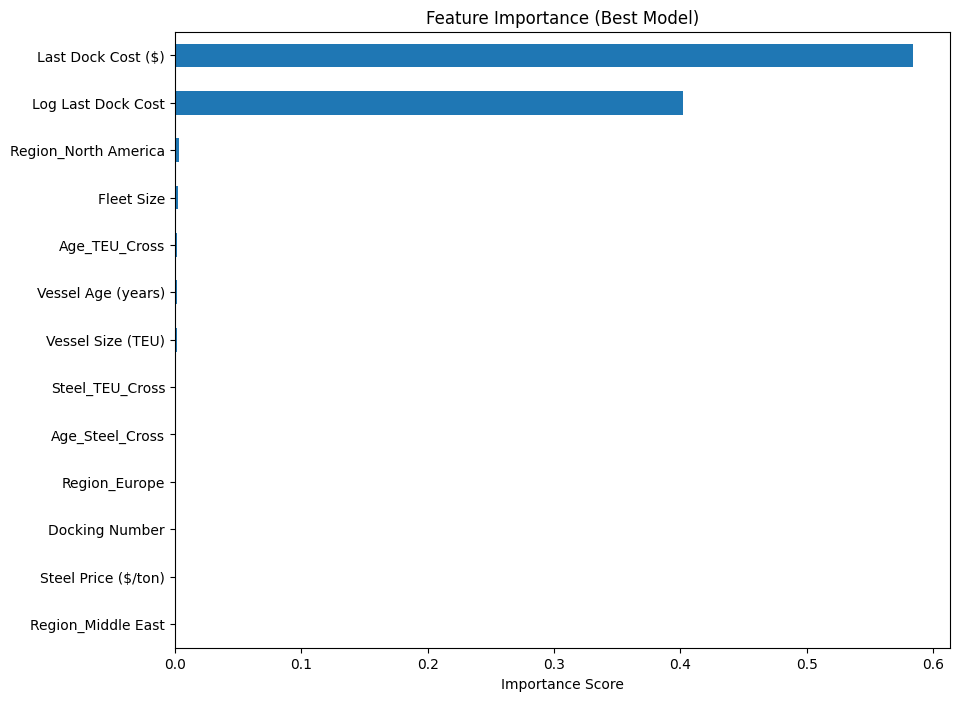

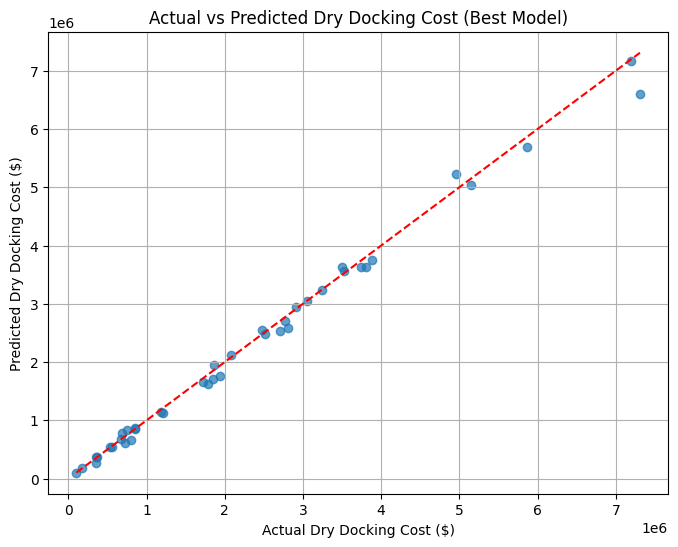

[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=5, n_estimators=500; total time=   0.

In [1]:
# 🚀 Dry Docking Cost Prediction Model (Log Transform + GradientBoosting + GridSearchCV)

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 2. Load Dataset
df = pd.read_csv('/Users/konstantinosmichalopoulos/Desktop/ML:Project DD/dataset.csv')

# 3. Prepare Data
df = df[df['Docking Number'] > 1]  # Drop first docking (no prior dock cost)

# Log-transform Dry Docking Cost and Last Dock Cost
df['Log Dry Docking Cost'] = np.log(df['Dry Docking Cost ($)'])
df['Log Last Dock Cost'] = np.log(df['Last Dock Cost ($)'])

# One-hot encode Region
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)

# 4. Create Cross Features
df_encoded['Age_TEU_Cross'] = df_encoded['Vessel Age (years)'] * df_encoded['Vessel Size (TEU)']
df_encoded['Steel_TEU_Cross'] = df_encoded['Steel Price ($/ton)'] * df_encoded['Vessel Size (TEU)']
df_encoded['Age_Steel_Cross'] = df_encoded['Vessel Age (years)'] * df_encoded['Steel Price ($/ton)']

# 5. Define Features (X) and Target (y)
X = df_encoded.drop(['Dry Docking Cost ($)', 'Log Dry Docking Cost', 'Vessel ID', 'Vessel Type', 'Year'], axis=1)
X['Log Last Dock Cost'] = df_encoded['Log Last Dock Cost']  # Replace normal last dock with log
y = df_encoded['Log Dry Docking Cost']

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Define Parameter Grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# 8. Base Model
base_model = GradientBoostingRegressor(random_state=42)

# 9. Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)

# 10. Fit GridSearchCV
grid_search.fit(X_train, y_train)

# 11. Best Model
best_model = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

# 12. Predict with Best Model
log_predictions_best = best_model.predict(X_test)
predictions_best = np.exp(log_predictions_best)  # Reverse log
true_values = np.exp(y_test)

# 13. Evaluate Best Model
mse_best = mean_squared_error(true_values, predictions_best)
rmse_best = mse_best**0.5
print(f"\nTest Set RMSE (Best Model): ${rmse_best:,.2f}")

# 14. Correct Cross-Validation for Best Model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_list = []

for train_idx, test_idx in cv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    model_cv = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)
    
    log_preds_cv = model_cv.predict(X_test_cv)
    preds_cv = np.exp(log_preds_cv)
    true_cv = np.exp(y_test_cv)
    
    mse_cv = mean_squared_error(true_cv, preds_cv)
    rmse_cv = np.sqrt(mse_cv)
    
    cv_rmse_list.append(rmse_cv)

print("\nCorrect Cross-Validation Results (Best Model):")
print(f"Mean CV RMSE: ${np.mean(cv_rmse_list):,.2f}")
print(f"Standard Deviation of CV RMSE: ${np.std(cv_rmse_list):,.2f}")

# 15. Feature Importance Plot
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Feature Importance (Best Model)')
plt.xlabel('Importance Score')
plt.show()

# 16. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(true_values, predictions_best, alpha=0.7)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
plt.title('Actual vs Predicted Dry Docking Cost (Best Model)')
plt.xlabel('Actual Dry Docking Cost ($)')
plt.ylabel('Predicted Dry Docking Cost ($)')
plt.grid(True)
plt.show()